# Aviation Accident Risk Analysis for Strategic Investment

## Goals

To help the company identify the lowest-risk aircraft models for commercial and private aviation.  
The goal is to analyze historical accident data to uncover patterns that can guide safe aircraft investments.


## Data

The dataset is from the National Transportation Safety Board (NTSB), covering civil aviation accidents from 1962 to 2023.  
The data includes accident details such as aircraft model, date, location, phase of flight, injury counts, and weather conditions.


In [44]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")

# Load pre-cleaned data 
df = pd.read_csv("df_cleaned.csv", index_col=0) 

df.head(2)

,Type,Date,Location,Country,Injury_Severity,Damage_type,Make,Model,Engines,Engine_Type,...,Weather,Month,Season,Year,City,State,Aircraft_Model,Total_Injuries,Is_Fatal,Aircraft_Age
ID,,,,,,,,,,,,,,,,,,,,,
20001218X45444,Accident,1948-10-24,"MOOSE CREEK, ID",United States,Fatal,Destroyed,STINSON,108-3,1.0,Reciprocating,...,UNKNOWN,10,Fall,1948,MOOSE CREEK,ID,STINSON 108-3,2,1,75
20001218X45447,Accident,1962-07-19,"BRIDGEPORT, CA",United States,Fatal,Destroyed,PIPER,PA24-180,1.0,Reciprocating,...,UNKNOWN,7,Summer,1962,BRIDGEPORT,CA,PIPER PA24-180,4,1,61


## Methods

We used the CRISP-DM methodology:
- Cleaned and standardized key columns (e.g., date, injuries, aircraft make/model)
- Conducted univariate, bivariate, and multivariate analysis
- Aggregated injuries by aircraft model and purpose of flight
- Created visualizations to highlight risk patterns


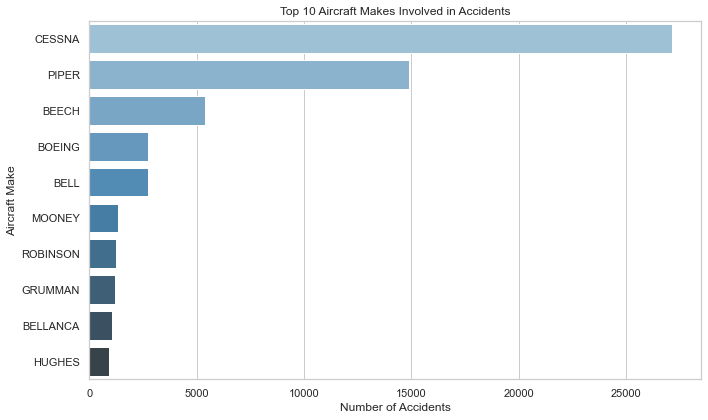

In [45]:
# Top 10 aircraft makes involved in accidents
top_makes = df["Make"].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(y=top_makes.index, x=top_makes.values, palette="Blues_d")
plt.title("Top 10 Aircraft Makes Involved in Accidents")
plt.xlabel("Number of Accidents")
plt.ylabel("Aircraft Make")
plt.tight_layout()
plt.show()

**Observation:** The most frequently involved makes are also likely to be the most used in civil aviation (e.g Cessna, Piper).

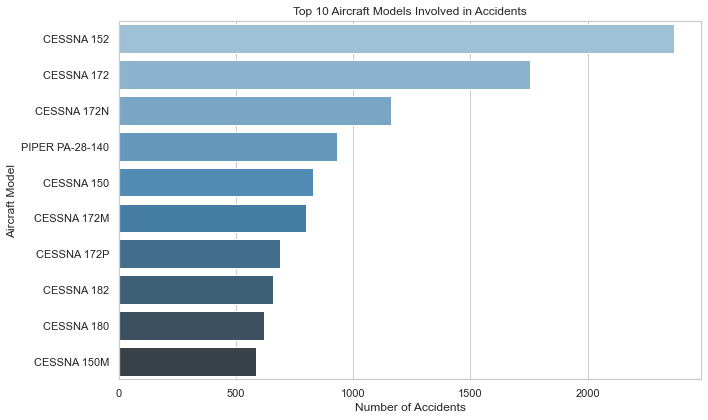

In [46]:
# Top 10 aircraft models involved in accidents
top_models = df["Aircraft_Model"].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(y=top_models.index, x=top_models.values, palette="Blues_d")
plt.title("Top 10 Aircraft Models Involved in Accidents")
plt.xlabel("Number of Accidents")
plt.ylabel("Aircraft Model")
plt.tight_layout()
plt.show()


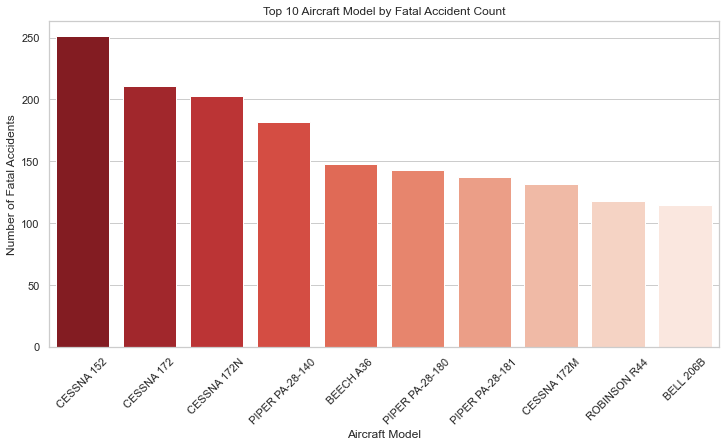

In [47]:
# Fatal injuries by aircraft model (top 10)

fatal_df = df[df['Injury_Severity'] == 'Fatal']
top_model = fatal_df['Aircraft_Model'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_model.index, y=top_model.values, palette='Reds_r')
plt.title('Top 10 Aircraft Model by Fatal Accident Count')
plt.xlabel('Aircraft Model')
plt.ylabel('Number of Fatal Accidents')
plt.xticks(rotation=45)
plt.show()


**Observation:** 
    Some aircraft have disproportionately high fatality counts, like Cessna 152, and 172. 
    These may present higher risk profiles depending on how widely they're used.

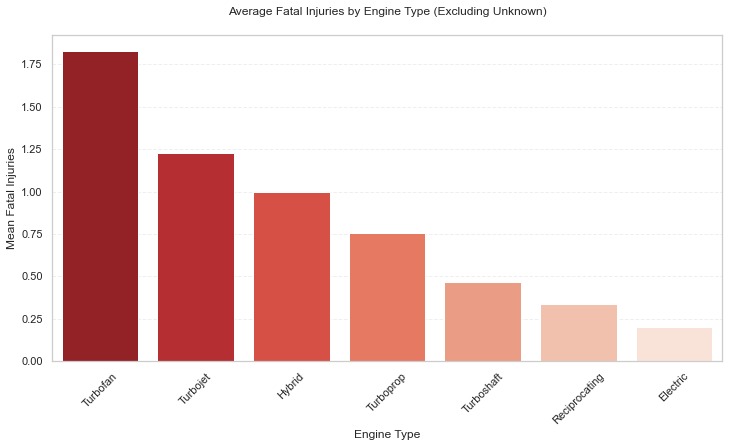

Reciprocating    69530
Turboshaft        3609
Turboprop         3391
Turbofan          2493
Turbojet           703
Electric            10
Hybrid               1
Name: Engine_Type, dtype: int64


In [48]:
#  Average Fatal Injuries by Engine Type, excluding unknown engine types

engine_fatal = df[df['Engine_Type'] != 'Unknown'].groupby('Engine_Type')['Fatal_Injuries'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=engine_fatal.index, 
    y=engine_fatal.values, 
    palette='Reds_r',
    order=engine_fatal.index  
)
plt.title('Average Fatal Injuries by Engine Type (Excluding Unknown)', pad=20)
plt.xlabel('Engine Type')
plt.ylabel('Mean Fatal Injuries')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


# Calculate the number of engine types
count_engine = df[df['Engine_Type'] != 'Unknown']['Engine_Type'].value_counts()
print(count_engine)

**Observation:** Turbofan engines show the highest mean fatal injuries (1.75 per accident), indicating these incidents are more severe despite potentially fewer occurrences.

In [49]:
# Calculating crash frequency and mean fatalities per flight-purpose
purpose_stats = df.groupby('Flight_Purpose').agg(
    Total_Crashes=('Flight_Purpose', 'size'),
    Mean_Fatalities=('Fatal_Injuries', 'mean'),
    Destroyed_Rate=('Damage_type', lambda x: (x == 'Destroyed').mean())
).sort_values('Total_Crashes', ascending=False).head(10)

print(purpose_stats)

                    Total_Crashes  Mean_Fatalities  Destroyed_Rate
Flight_Purpose                                                    
Personal                    49448         0.379429        0.213558
Instructional               10601         0.180455        0.114329
Unknown                      6802         1.439136        0.256542
Aerial Application           4712         0.116511        0.226868
Business                     4018         0.575660        0.295172
Positioning                  1646         0.385784        0.250304
Other Work Use               1264         0.404272        0.210443
Ferry                         812         0.475369        0.289409
Aerial Observation            794         0.521411        0.283375
Public Aircraft               720         0.563889        0.290278


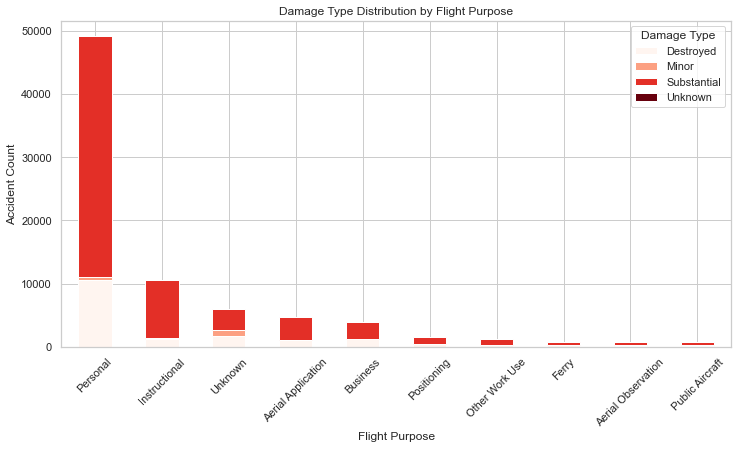

In [50]:
# Calculate damage type counts per purpose
damage_type = df.groupby(['Flight_Purpose', 'Damage_type']).size().unstack().fillna(0)
damage_type = damage_type.loc[purpose_stats.index] 

# Plot
damage_type.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Reds')
plt.title('Damage Type Distribution by Flight Purpose')
plt.xlabel('Flight Purpose')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.legend(title='Damage Type', bbox_to_anchor=(1, 1)) 
plt.show()

*Observation:* 
    Business has the highest proportion of Destroyed (red segments).
    Personal dominates in volume but with mostly minor/substantial damage.

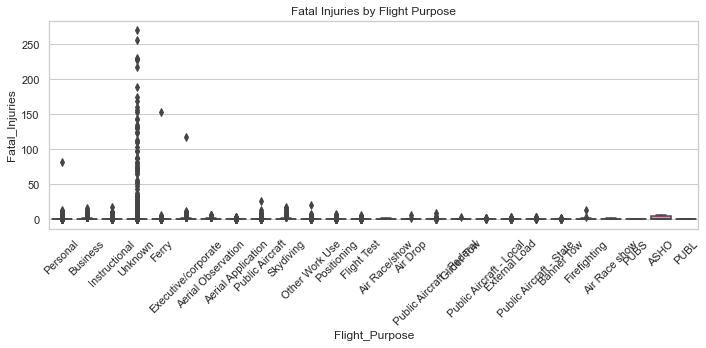

In [51]:
# Boxplot of fatal injuries by flight purpose
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="Flight_Purpose", y="Fatal_Injuries")
plt.xticks(rotation=45)
plt.title("Fatal Injuries by Flight Purpose")
plt.tight_layout()
plt.show()

**Observation:** 
Training and personal flights show higher variability and median fatal injuries than commercial flights indicating less controlled environments.

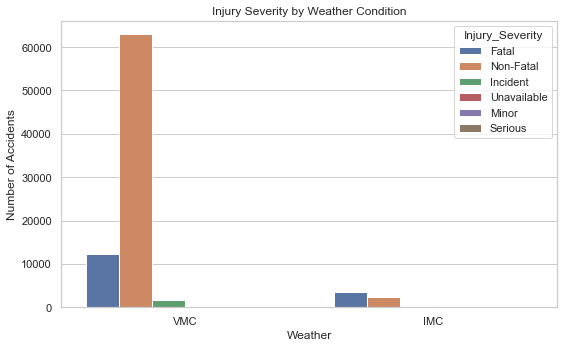

In [52]:
# Countplot of injury severity by weather
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Weather", hue="Injury_Severity", order=["VMC", "IMC"])
plt.title("Injury Severity by Weather Condition")
plt.xlabel("Weather")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

**Observation:** 
    More accidents (and severe injuries) occur under VMC (good) weather suggesting human factors dominate over weather in risk analysis.

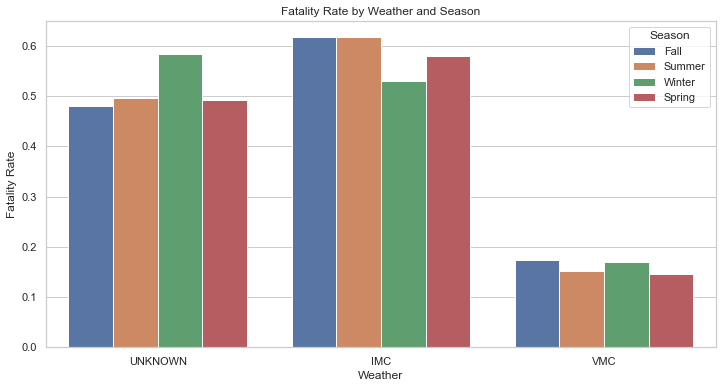

In [53]:
# Fatality rate by Weather AND Season
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Weather', y='Is_Fatal', hue='Season', estimator=np.mean, errorbar=None)
plt.title('Fatality Rate by Weather and Season')
plt.ylabel('Fatality Rate')
plt.show()

**Observation:**

1. Across all seasons, the fatality rate in IMC (poor visibility) is significantly higher than in VMC (clear weather).
2. The Winter-IMC bar is tallest than Winter-VMC, confirming cold + poor visibility is the deadliest combo. 
3. Summer is the safest but still risky in IMC

In [54]:
# Show fatality rates per group
crosstab = pd.crosstab(index=[df['Weather'], df['Damage_type']], 
                      columns=df['Is_Fatal'], normalize='index') 
print(crosstab.loc[:, 1])  # Fatality rates per group

Weather  Damage_type
IMC      Destroyed      0.879377
         Minor          0.011976
         Substantial    0.228622
UNKNOWN  Destroyed      0.869403
         Minor          0.020619
         Substantial    0.257534
         Unknown        0.250000
VMC      Destroyed      0.610708
         Minor          0.051785
         Substantial    0.060342
         Unknown        0.131579
Name: 1, dtype: float64


*Observation:* 

Poor weather (IMC) and extensive damage (Destroyed) are strongly associated with fatal injuries. 87.9% fatality rate (IMC-Destroyed) vs. 61.1% (VMC-Destroyed).

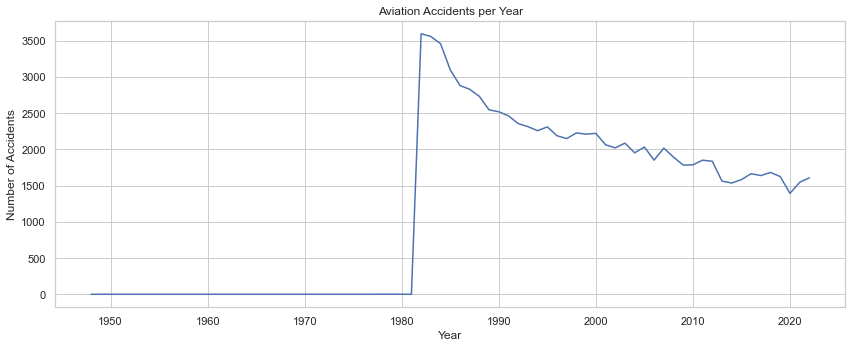

In [55]:
# Accidents per year
accident_trend = df["Year"].value_counts().sort_index()

plt.figure(figsize=(12,5))
accident_trend.plot()
plt.title("Aviation Accidents per Year")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

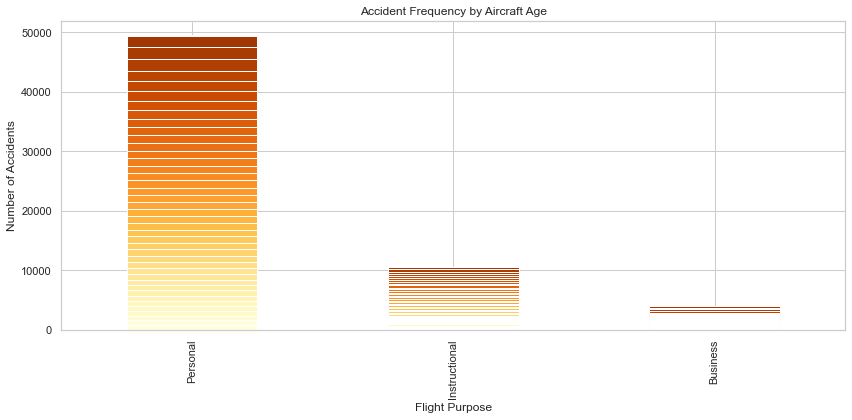

In [56]:
# Does aircraft age matter?
df['Aircraft_Age'] = 2023 - df['Year']

age_counts = df.groupby(['Flight_Purpose', 'Aircraft_Age']).size().unstack()

age_counts.loc[['Personal', 'Instructional', 'Business']].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=sns.color_palette('YlOrBr', len(age_counts.columns)),
    legend=False)

plt.title('Accident Frequency by Aircraft Age')
plt.xlabel('Flight Purpose')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

**Observation:** 
    
    Personal/Instructional flights (private/training) have taller bars, confirming they crash more frequently.
    
    Business flights have fewer accidents overall, but still age-sensitive therefore we should prioritizing newer models for all operations.

## Results

- Most accidents occurred from 1980 and have been declining since.
- A small number of aircraft makes are involved in a majority of severe accidents.
- Training and private-use flights tend to have higher injury rates than commercial flights.
- Certain aircraft models consistently show low injury rates per incident.


### Business Recommendation 1

Invest in aircraft models with historically low total injuries per incident.  

Focusing investments on aircraft models with consistently low fatality/injury counts, because some aircraft have disproportionately high fatality counts, like Cessna 152, and 172. These may present higher risk profiles depending on how widely they're used.


### Business Recommendation 2

Start with commercial-use aircraft types with strong safety records, then expand based on risk-adjusted performance.  
Consider insurance and maintenance costs as part of the decision process.


### Business Recommendation 3

Invest in Weather Avoidance Technology such as real-time weather radar and terrain awareness systems (e.g., TAWS), and partner with providers like ForeFlight or Garmin for predictive weather analytics in order to manage poor weather(IMC). 

Budget for training of all pilots operating in IMC-prone regions.

Invest in automated weather reporting from aircraft to reduce the unknowns and for better predictability. 

### Business Recommendation 4

Avoid older models and aircraft used predominantly in private or training settings.  
These showed a higher number of accidents and severe injuries.
